# Import

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import re
import time
import random

from wordcloud import WordCloud

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from collections import defaultdict, Counter

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, cluster, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.optimize import linear_sum_assignment

import tensorflow as tf
import tensorflow.keras
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam

from keras.applications import MobileNetV2

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel

from datasets import load_metric, Dataset

import gensim
from gensim.models import Word2Vec

from PIL import Image, ImageEnhance

import cv2

import locale
import os
import zipfile
import urllib
import sqlite3
import sys


# Obtenir le répertoire de travail courant (répertoire du notebook)
current_dir = os.getcwd()

# Chemin relatif vers le répertoire contenant fonctions.py
relative_path = 'Openclassrooms'

# Chemin absolu vers le répertoire contenant fonctions.py
absolute_path = os.path.join(current_dir, relative_path)

# Insérer le chemin relatif dans sys.path
sys.path.insert(1, absolute_path)

# Importer les fonctions depuis fonctions.py
from fonctions import data_information, doublons

In [5]:
def print_versions():
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Seaborn: {sns.__version__}")
    print(f"NetworkX: {nx.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    
    # WordCloud ne possède pas __version__
    try:
        from wordcloud import __version__ as wordcloud_version
    except ImportError:
        wordcloud_version = "not available"
    print(f"WordCloud: {wordcloud_version}")

    print(f"NLTK: {nltk.__version__}")

    print(f"Scikit-learn: {sklearn.__version__}")

    print(f"TensorFlow: {tf.__version__}")
    print(f"TensorFlow Keras: {tensorflow.keras.__version__}")
    print(f"TensorFlow Hub: {hub.__version__}")

    print(f"PyTorch: {torch.__version__}")

    try:
        import transformers
        print(f"Transformers: {transformers.__version__}")
    except ImportError:
        print("Transformers: not available")

    print(f"Gensim: {gensim.__version__}")

    print(f"Pillow: {Image.__version__}")
    print(f"OpenCV: {cv2.__version__}")

print_versions()

Pandas: 1.5.3
NumPy: 1.24.3
Seaborn: 0.13.2
NetworkX: 3.3
Matplotlib: 3.9.0
WordCloud: 1.9.3
NLTK: 3.7
Scikit-learn: 1.2.2
TensorFlow: 2.16.1
TensorFlow Keras: 3.3.3
TensorFlow Hub: 0.16.1
PyTorch: 2.0.1
Transformers: 4.29.2
Gensim: 4.3.0
Pillow: 10.0.1
OpenCV: 4.10.0


In [6]:
data = pd.read_csv('data_projet6.csv')

In [7]:
display(data_information(data))

Nombre de ligne : 1050 Nombre de colonne : 23
------
Types des variables :
object     19
float64     2
bool        1
int64       1
dtype: int64
------
% de valeurs manquantes par colonne : 


cat_product_7              0.945714
cat_product_6              0.879048
cat_product_5              0.614286
cat_product_4              0.353333
brand                      0.321905
cat_product_3              0.002857
retail_price               0.000952
discounted_price           0.000952
product_specifications     0.000952
cat_product_2              0.000000
cat_product_1              0.000000
category_count             0.000000
uniq_id                    0.000000
overall_rating             0.000000
crawl_timestamp            0.000000
description                0.000000
is_FK_Advantage_product    0.000000
image                      0.000000
pid                        0.000000
product_category_tree      0.000000
product_name               0.000000
product_url                0.000000
product_rating             0.000000
dtype: float64

None

In [4]:
# Augmentation de la limite de la taille des images en pixel
Image.MAX_IMAGE_PIXELS = 93680328 

# Fonctions

In [5]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, l_cat, y_cat_num):
    time1 = time.time()
    num_labels = len(l_cat)
    
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

In [7]:
def conf_mat_transform(y_true, y_pred, l_cat, class_labels, ax, labels):
    """
    Transforme les étiquettes prédites pour correspondre aux vraies catégories 
    en maximisant les valeurs sur la diagonale de la matrice de confusion.

    Args:
    - y_true: Étiquettes réelles
    - y_pred: Étiquettes prédites
    - l_cat: Liste des catégories pour la transformation des labels
    - class_labels: Étiquettes réelles sous forme de chaînes pour l'affichage
    - ax: L'axe matplotlib sur lequel tracer la matrice de confusion
    - labels: Étiquettes des clusters

    Returns:
    - y_pred_transform: Étiquettes prédites transformées pour correspondre aux vraies catégories
    """
    # Calcul de la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    print("Matrice de confusion originale:\n", conf_mat)
    
    # Création de la matrice de coût pour trouver la meilleure correspondance
    cost_matrix = -conf_mat  # On maximise sur la diagonale en minimisant le coût
    
    # Trouver la meilleure permutation des colonnes pour maximiser les valeurs sur la diagonale
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Réordonner les colonnes de la matrice de confusion en fonction de la meilleure permutation
    conf_mat_transformed = conf_mat[:, col_ind]
    print("Matrice de confusion transformée:\n", conf_mat_transformed)
    
    # Créer un mappage entre les clusters et les vraies catégories
    cluster_to_category = {i: col_ind[i] for i in range(len(col_ind))}
    
    # Transformer les étiquettes prédites pour qu'elles correspondent aux vraies catégories
    y_pred_transform = np.array([cluster_to_category[cluster] for cluster in y_pred])
    
    # Assurez-vous que `labels` est une liste
    if isinstance(labels, set):
        labels = list(labels)
    
    # Création d'un DataFrame pour une meilleure visualisation
    df_cm = pd.DataFrame(conf_mat_transformed, index=class_labels, columns=labels)
    
    # Affichage de la matrice de confusion
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', ax=ax)
    ax.set_xlabel('Prédictions')
    ax.set_ylabel('Vérités terrain')
    ax.set_title('Matrice de confusion')

    return y_pred_transform, df_cm

In [8]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat):
    """
    Visualisation des résultats TSNE avec la matrice de confusion.
    
    Args:
    - X_tsne: Données TSNE transformées
    - y_cat_num: Étiquettes catégorielles numériques
    - labels: Étiquettes des clusters
    - ARI: Indice d'ajustement de Rand (si nécessaire)
    - l_cat: Liste des catégories
    """
    # Encoder les catégories en nombres pour la coloration
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    fig, axs = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # Premier graphique : Représentation des descriptions par catégories réelles
    scatter1 = axs[0, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    handles1, _ = scatter1.legend_elements()
    legend1 = axs[0, 0].legend(handles1, l_cat, loc='upper center', title="Catégories", ncol=1)
    axs[0, 0].add_artist(legend1)
    axs[0, 0].set_title('Représentation des images par catégories réelles')
    
    # Deuxième graphique : Représentation des descriptions par clusters
    scatter2 = axs[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=encoded_labels, cmap='Set1')
    handles2, _ = scatter2.legend_elements()
    legend2 = axs[0, 1].legend(handles2, set(encoded_labels), loc='upper center', title="Clusters", ncol=1)
    axs[0, 1].add_artist(legend2)
    axs[0, 1].set_title('Représentation des images par clusters')
    
    # Troisième graphique : Matrice de confusion
    y_pred_transform, df_cm = conf_mat_transform(y_cat_num, encoded_labels, 
                                                 l_cat, l_cat, axs[1, 1], set(encoded_labels))
    
    # Supprimer le quatrième subplot vide
    fig.delaxes(axs[1, 0])
    
    plt.tight_layout()
    plt.show()

In [9]:
def extract_features(generator, model):
    features = []
    labels = []
    
    for i in range(len(generator)):
        x_batch, y_batch = next(generator)  # Utiliser next(generator) pour obtenir le prochain batch
        features_batch = model.predict(x_batch)
        features.append(features_batch)
        labels.append(y_batch)
    
    # Convertir les listes en tableaux numpy
    features = np.vstack(features)
    labels = np.concatenate(labels)
    
    return features, labels

# Analyse des images

In [9]:
# Grouper par 'cat_product_1' et 'image', puis compter les occurrences
image_distribution = data.groupby('cat_product_1')['image'].count()

# Afficher le résultat
print(image_distribution)

cat_product_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: image, dtype: int64


**COMMENTAIRE**

On remarque une distribution homogème des produits dans les différentes catégories produits.

In [10]:
# Chemin du dossier contenant les images
image_folder = './Flipkart/images'

# Variables pour stocker les statistiques générales
unique_sizes = set()
horizontal_count = 0
vertical_count = 0
square_count = 0
max_width = 0
max_height = 0
min_width = float('inf')
min_height = float('inf')

# Parcourir chaque image dans le dossier spécifié
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    try:
        # Ouvrir l'image et récupérer sa taille
        image = Image.open(image_path)
        width, height = image.size
        
        # Ajouter la taille à l'ensemble des tailles uniques
        unique_sizes.add((width, height))
        
        # Mettre à jour le compteur d'images horizontales et verticales
        if width >= height:
            horizontal_count += 1
        elif width == height:
            square_count+= 1
        else:
            vertical_count += 1
        
        # Mettre à jour les tailles maximales et minimales
        max_width = max(max_width, width)
        max_height = max(max_height, height)
        min_width = min(min_width, width)
        min_height = min(min_height, height)
    
    except Exception as e:
        print(f"Erreur lors du traitement de l'image {image_name} : {str(e)}")

# Afficher les statistiques générales
print("Statistiques générales des images :")
print(f"Nombre de tailles différentes : {len(unique_sizes)}")
print(f"Nombre d'images horizontales : {horizontal_count}")
print(f"Nombre d'images verticales : {vertical_count}")
print(f"Nombre d'images carrées : {square_count}")
print(f"Taille maximale : ({max_width}, {max_height})")
print(f"Taille minimale : ({min_width}, {min_height})")

Statistiques générales des images :
Nombre de tailles différentes : 890
Nombre d'images horizontales : 521
Nombre d'images verticales : 529
Nombre d'images carrées : 0
Taille maximale : (8484, 11042)
Taille minimale : (145, 160)


## Traitement image

In [11]:
# Affichage de quelques images

# Fonction pour afficher une image
def show_image_row(df, row_index):
    image_name = df.iloc[row_index]['image']
    category = df.iloc[row_index]['cat_product_1']
    image_path = os.path.join(image_folder, image_name)
    
    if os.path.exists(image_path):
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(f'Catégorie: {category}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image {image_name} not found in {image_folder}")

In [12]:
# On prend la première image de data
row_index = 1

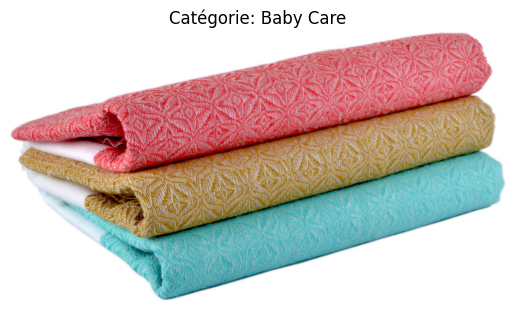

In [13]:
show_image_row(data, row_index)

In [14]:
# On affiche 1 image par catégorie
def show_image(image_path, category):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Catégorie: {category}')
    plt.axis('off')
    plt.show()

def show_images_per_category(df, image_folder):
    unique_categories = df['cat_product_1'].unique()
    for category in unique_categories:
        # Trouver la première occurrence de cette catégorie
        row = df[df['cat_product_1'] == category].iloc[0]
        image_name = row['image']
        image_path = os.path.join(image_folder, image_name)
        
        if os.path.exists(image_path):
            show_image(image_path, category)
        else:
            print(f"Image {image_name} not found in {image_folder}")

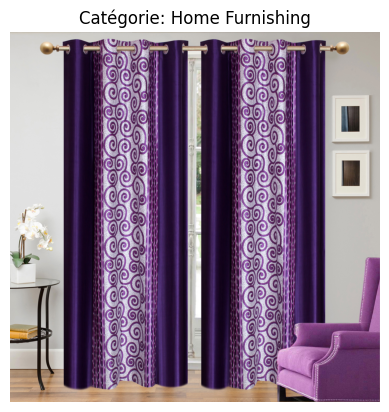

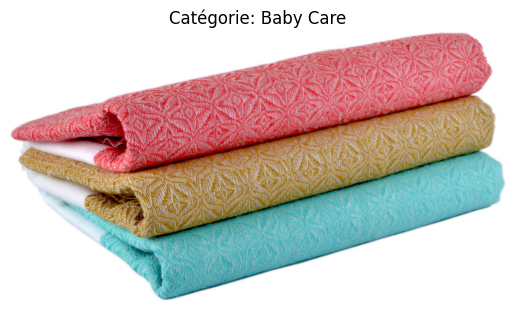

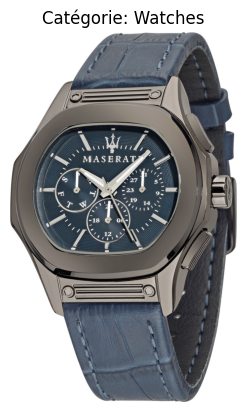

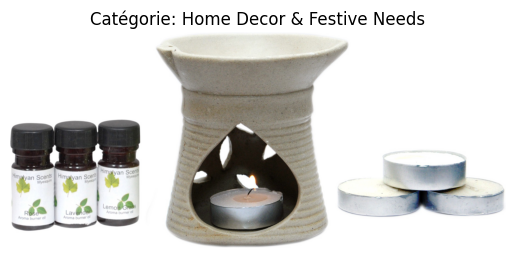

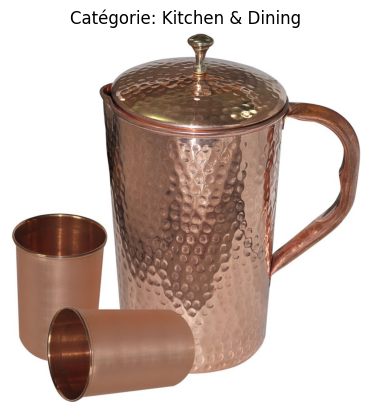

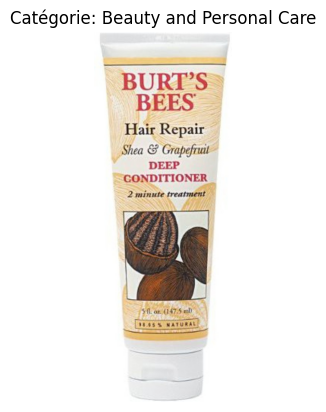

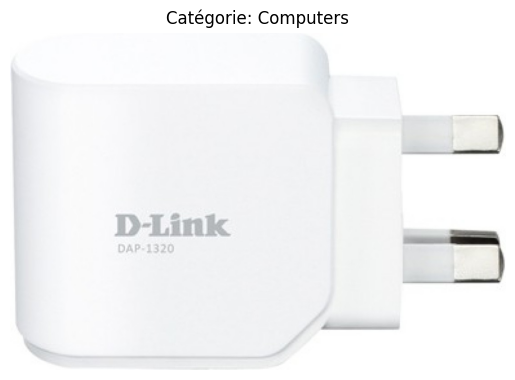

In [15]:
show_images_per_category(data, image_folder)

**COMMENTAIRE**

On peut voir plusieurs types de photos :
- un produit unique et détouré
- des produits détourés
- produit dans une mise en scene (-> si on voit uniquement la photo on se demande quel est le produit )

In [16]:
def show_image_gray(image_path):
    image = Image.open(image_path)
    image_gray = image.convert('L')  # Convertir en niveaux de gris
    return np.array(image_gray)  # Retourner l'image sous forme de tableau NumPy

def show_image_noise_filter(image_path):
    image = cv2.imread(image_path)
    image_filtered = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)  # Filtrage du bruit
    return cv2.cvtColor(image_filtered, cv2.COLOR_BGR2RGB)  # Retourner l'image filtrée en RGB

def show_image_contrast_adjust(image_path, factor=1.5):
    image = Image.open(image_path)
    enhancer = ImageEnhance.Contrast(image)
    image_contrast = enhancer.enhance(factor)  # Ajustement du contraste
    return np.array(image_contrast).astype(np.float32)  # Retourner l'image sous forme de tableau NumPy en float32

In [17]:
def show_images_per_category(df, image_folder):
    unique_categories = df['cat_product_1'].unique()
    num_categories = len(unique_categories)
    
    fig, axes = plt.subplots(num_categories, 3, figsize=(15, num_categories * 5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)
    
    for idx, category in enumerate(unique_categories):
        row = df[df['cat_product_1'] == category].iloc[0]
        image_name = row['image']
        image_path = os.path.join(image_folder, image_name)
        
        if os.path.exists(image_path):
            # Affichage en niveaux de gris
            image_gray = show_image_gray(image_path) / 255.0
            axes[idx, 0].imshow(image_gray, cmap='gray')
            axes[idx, 0].set_title(f'Catégorie: {category} - Niveaux de gris')
            axes[idx, 0].axis('off')
            
            # Affichage filtrage de bruit
            image_filtered = show_image_noise_filter(image_path).astype(np.float32) / 255.0
            axes[idx, 1].imshow(image_filtered)
            axes[idx, 1].set_title(f'Catégorie: {category} - Filtrage de bruit')
            axes[idx, 1].axis('off')
            
            # Affichage ajustement du contraste
            image_contrast = show_image_contrast_adjust(image_path) / 255.0
            axes[idx, 2].imshow(image_contrast)
            axes[idx, 2].set_title(f'Catégorie: {category} - Ajustement du contraste')
            axes[idx, 2].axis('off')
            
        else:
            print(f"Image {image_name} not found in {image_folder}")
    
    plt.tight_layout()
    plt.show()

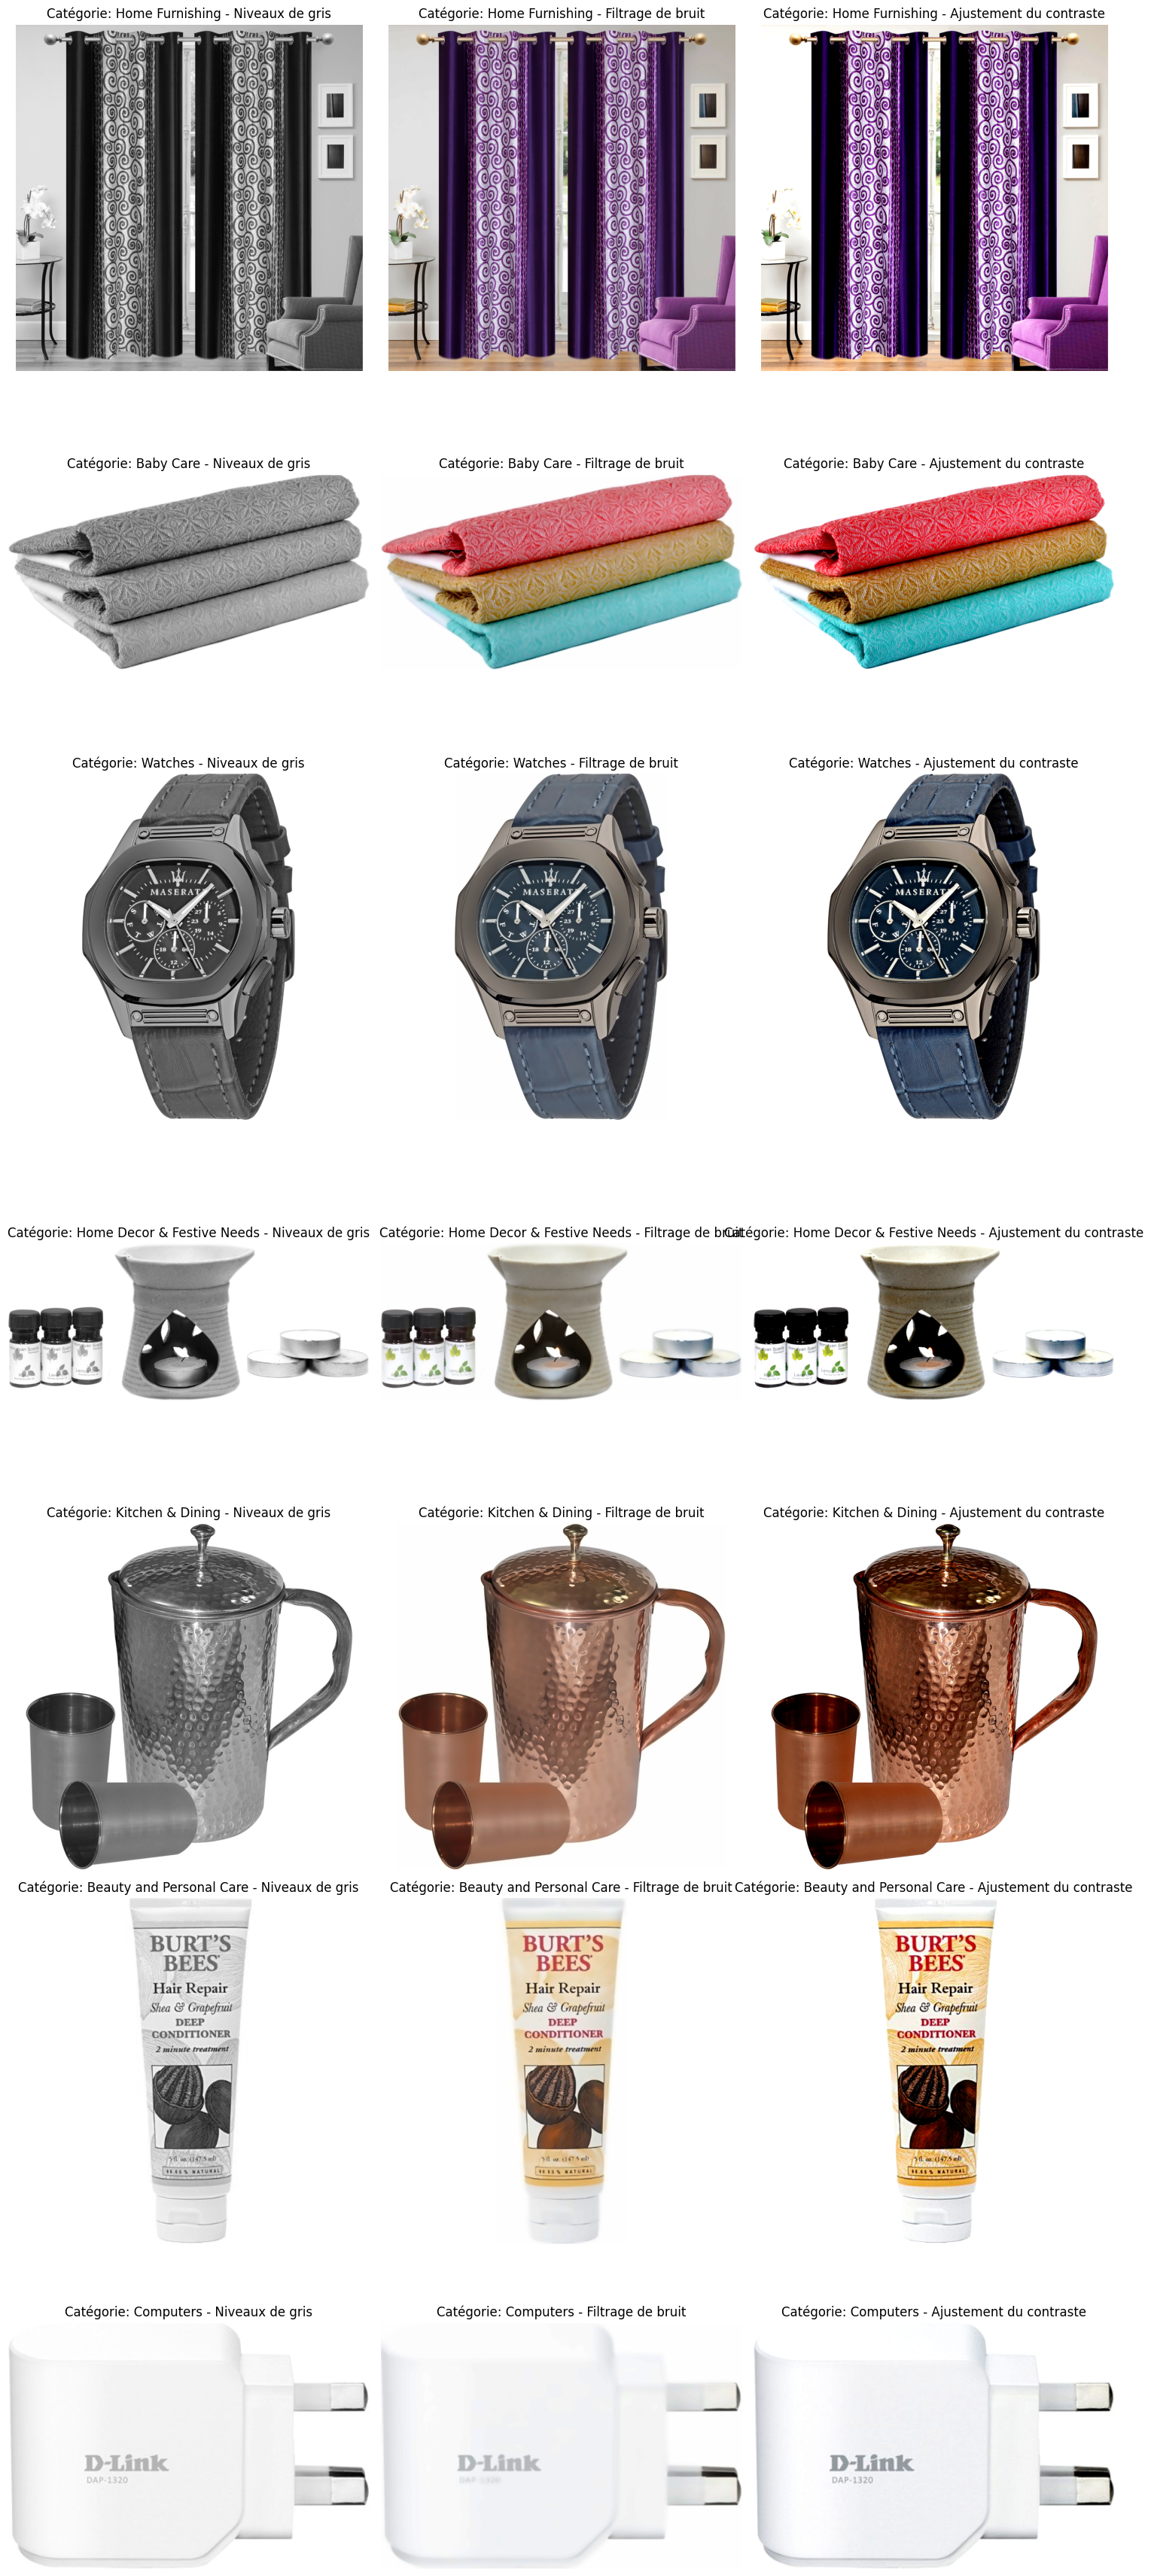

In [18]:
show_images_per_category(data, image_folder)

**Commentaire**

- Le filtrage bruit permet de voir plus de détail comme pour la photo de la catégorie Beauty
- L'ajustement du contraste permet de mettre en évidence les textes qu'il y a sur les photos

# Extraction des features

Pour l'extraction de feature nous avons commencé par tester ORB pour sa rapidité, le projet étant de catégoriser des produits lors de la création de fiche produit la rapidité est un point important d'un point de vue métier.

## ORB

In [19]:
def load_image(image_path):
    return cv2.imread(image_path)

# Initialisation de l'extracteur ORB
def initialize_orb():
    orb = cv2.ORB_create(nfeatures=1000)  # Nombre de keypoints à détecter
    return orb

In [20]:
def extract_features_orb(image, orb):
    # Conversion en niveaux de gris si l'image est en couleur
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # Déjà en niveaux de gris
    
    # Détection des keypoints et calcul des descripteurs
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    return keypoints, descriptors

def draw_keypoints(image, keypoints):
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [21]:
def get_image_path_by_category(df, category, image_folder):
    row = df[df['cat_product_1'] == category].iloc[0]  # On prend la première occurrence de la catégorie
    image_name = row['image']
    image_path = os.path.join(image_folder, image_name)
    
    if os.path.exists(image_path):
        return image_path
    else:
        print(f"Image {image_name} not found in {image_folder}")
        return None

Catégorie: Home Furnishing


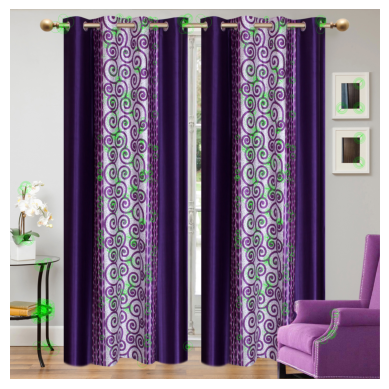

Catégorie: Baby Care


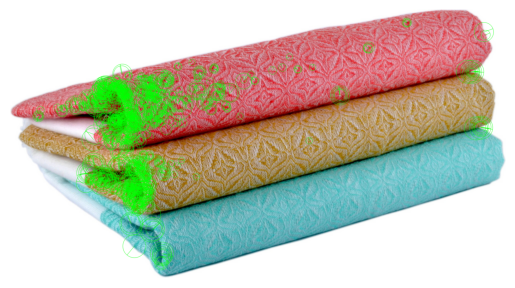

Catégorie: Watches


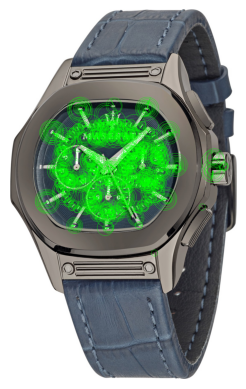

Catégorie: Home Decor & Festive Needs


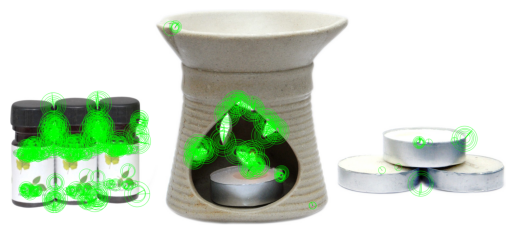

Catégorie: Kitchen & Dining


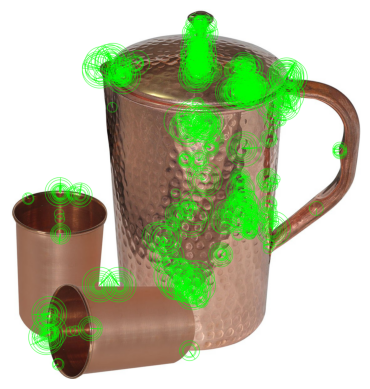

Catégorie: Beauty and Personal Care


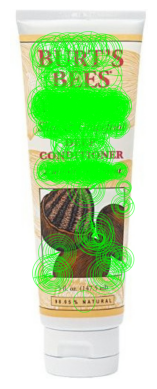

Catégorie: Computers


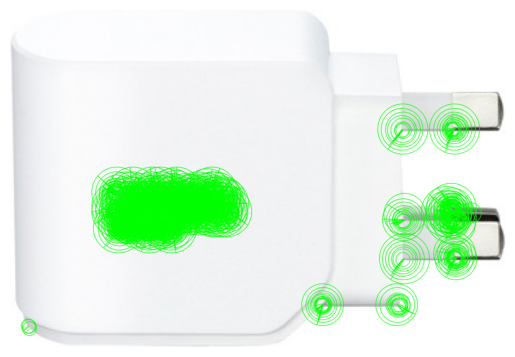


Chemins des premières images par catégorie :
Catégorie 'Home Furnishing': ./Flipkart/images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
Catégorie 'Baby Care': ./Flipkart/images/7b72c92c2f6c40268628ec5f14c6d590.jpg
Catégorie 'Watches': ./Flipkart/images/893aa5ed55f7cff2eccea7758d7a86bd.jpg
Catégorie 'Home Decor & Festive Needs': ./Flipkart/images/f0938b0d88eac91deee6d5add54097d3.jpg
Catégorie 'Kitchen & Dining': ./Flipkart/images/e9420e9483f16db81c64dddf99f34841.jpg
Catégorie 'Beauty and Personal Care': ./Flipkart/images/2d50e4c6ccf8befe9335ac8f97a11712.jpg
Catégorie 'Computers': ./Flipkart/images/d1899ab1d5c79ddaa311bc9f04d198ed.jpg


In [22]:
# Liste des catégories uniques
unique_categories = data['cat_product_1'].unique()

# Dictionnaire pour stocker les chemins des premières images par catégorie
first_images_paths = {}

# Parcourir chaque catégorie et afficher la première image avec les keypoints ORB
for category in unique_categories:
    image_path = get_image_path_by_category(data, category, image_folder)
    if image_path:
        first_images_paths[category] = image_path
        print(f"Catégorie: {category}")
        image = load_image(image_path)
        orb = initialize_orb()
        keypoints, _ = extract_features_orb(image, orb)
        draw_keypoints(image, keypoints)
    else:
        print(f"Aucune image trouvée pour la catégorie '{category}'")

# Affichage des chemins des premières images par catégorie
print("\nChemins des premières images par catégorie :")
for category, image_path in first_images_paths.items():
    print(f"Catégorie '{category}': {image_path}")

### PCA

In [23]:
# Fonction pour appliquer PCA et t-SNE
def apply_pca_tsne(features):
    # Réduction de dimension avec PCA
    pca = PCA(n_components=2) 
    features_pca = pca.fit_transform(features)
    
    # Réduction supplémentaire avec t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features_pca)
    
    return X_tsne

**Commentaire**

L'extraction des features avec ORB est très long, ici nous réalisons une étude de faisabilité. On choisi donc de prendre un sous échantillon.

In [24]:
def sample_keypoints(image, orb, num_samples=20):
    """
    Échantillonne un sous-ensemble aléatoire des points d'intérêt.
    
    Args:
    - image: Image en niveaux de gris.
    - orb: Instance de l'ORB.
    - num_samples: Nombre de descripteurs à conserver.

    Returns:
    - keypoints: Liste des points d'intérêt.
    - descriptors: Descripteurs correspondants.
    """
    keypoints, descriptors = orb.detectAndCompute(image, None)
    
    if descriptors is not None:
        indices = random.sample(range(len(descriptors)), min(num_samples, len(descriptors)))
        keypoints = [keypoints[i] for i in indices]
        descriptors = descriptors[indices]
    
    return keypoints, descriptors

In [25]:
all_descriptors = []
all_categories = []

categories = data['cat_product_1']
l_cat = list(categories.unique())
y_cat_num = categories.apply(lambda x: l_cat.index(x))

# Initialiser l'ORB
orb = cv2.ORB_create()

# Parcourir les premières 1000 images dans le dossier
for i, image_name in enumerate(os.listdir(image_folder)):
    if i >= 1000:
        break
    
    image_path = os.path.join(image_folder, image_name)
    image = load_image(image_path)
    
    # Extraire les points d'intérêt et descripteurs
    keypoints, descriptors = sample_keypoints(image, orb, num_samples=20)
    
    if descriptors is not None:
        all_descriptors.append(descriptors)
        
        # Identifier la catégorie de l'image actuelle
        category = data.loc[data['image'] == image_name, 'cat_product_1'].values[0]
        
        # Étendre la liste des catégories avec la catégorie actuelle
        all_categories.extend([category] * len(descriptors))

# Convertir les descripteurs en numpy array
all_descriptors = np.vstack(all_descriptors)

# Convertir les catégories en numpy array et en labels numériques
all_categories = np.array(all_categories)
y_cat_num = np.array([l_cat.index(cat) for cat in all_categories])

In [26]:
# Diviser les descripteurs en ensembles d'entraînement et de test
descriptors_train, descriptors_test, y_train, y_test = train_test_split(
    all_descriptors, y_cat_num, test_size=0.2, random_state=42)

In [27]:
print(descriptors.shape)
print(descriptors_train.shape)
print(descriptors_test.shape)

(20, 32)
(15972, 32)
(3993, 32)


In [28]:
# Appliquer PCA et t-SNE sur les descripteurs d'entraînement
descriptors_tsne_train = apply_pca_tsne(descriptors_train)

### Prédiction

In [29]:
# Effectuer le clustering sur les données transformées
kmeans = KMeans(n_clusters=7, n_init=100, random_state=42)
cluster_labels = kmeans.fit_predict(descriptors_tsne_train)

### Evaluation

In [30]:
# Comparaison avec les catégories réelles
#true_labels = data['cat_product_1']

# Calculer l'indice de silhouette pour évaluer la qualité du clustering
#silhouette = silhouette_score(descriptors_pca, cluster_labels)
#print(f"Indice de silhouette du clustering : {silhouette}")

In [31]:
# Calculer ARI et visualiser les résultats pour les données d'entraînement
ARI_train, X_tsne_train, labels_train = ARI_fct(descriptors_tsne_train, l_cat, y_train)

ARI :  0.0007 time :  64.0


Matrice de confusion originale:
 [[371 328 354 363 307 275 321]
 [335 335 324 383 356 349 254]
 [278 346 297 364 335 299 289]
 [373 300 302 381 282 284 326]
 [325 414 296 397 342 305 281]
 [366 320 287 358 341 246 345]
 [299 362 283 375 307 303 309]]
Matrice de confusion transformée:
 [[354 275 307 371 328 321 363]
 [324 349 356 335 335 254 383]
 [297 299 335 278 346 289 364]
 [302 284 282 373 300 326 381]
 [296 305 342 325 414 281 397]
 [287 246 341 366 320 345 358]
 [283 303 307 299 362 309 375]]


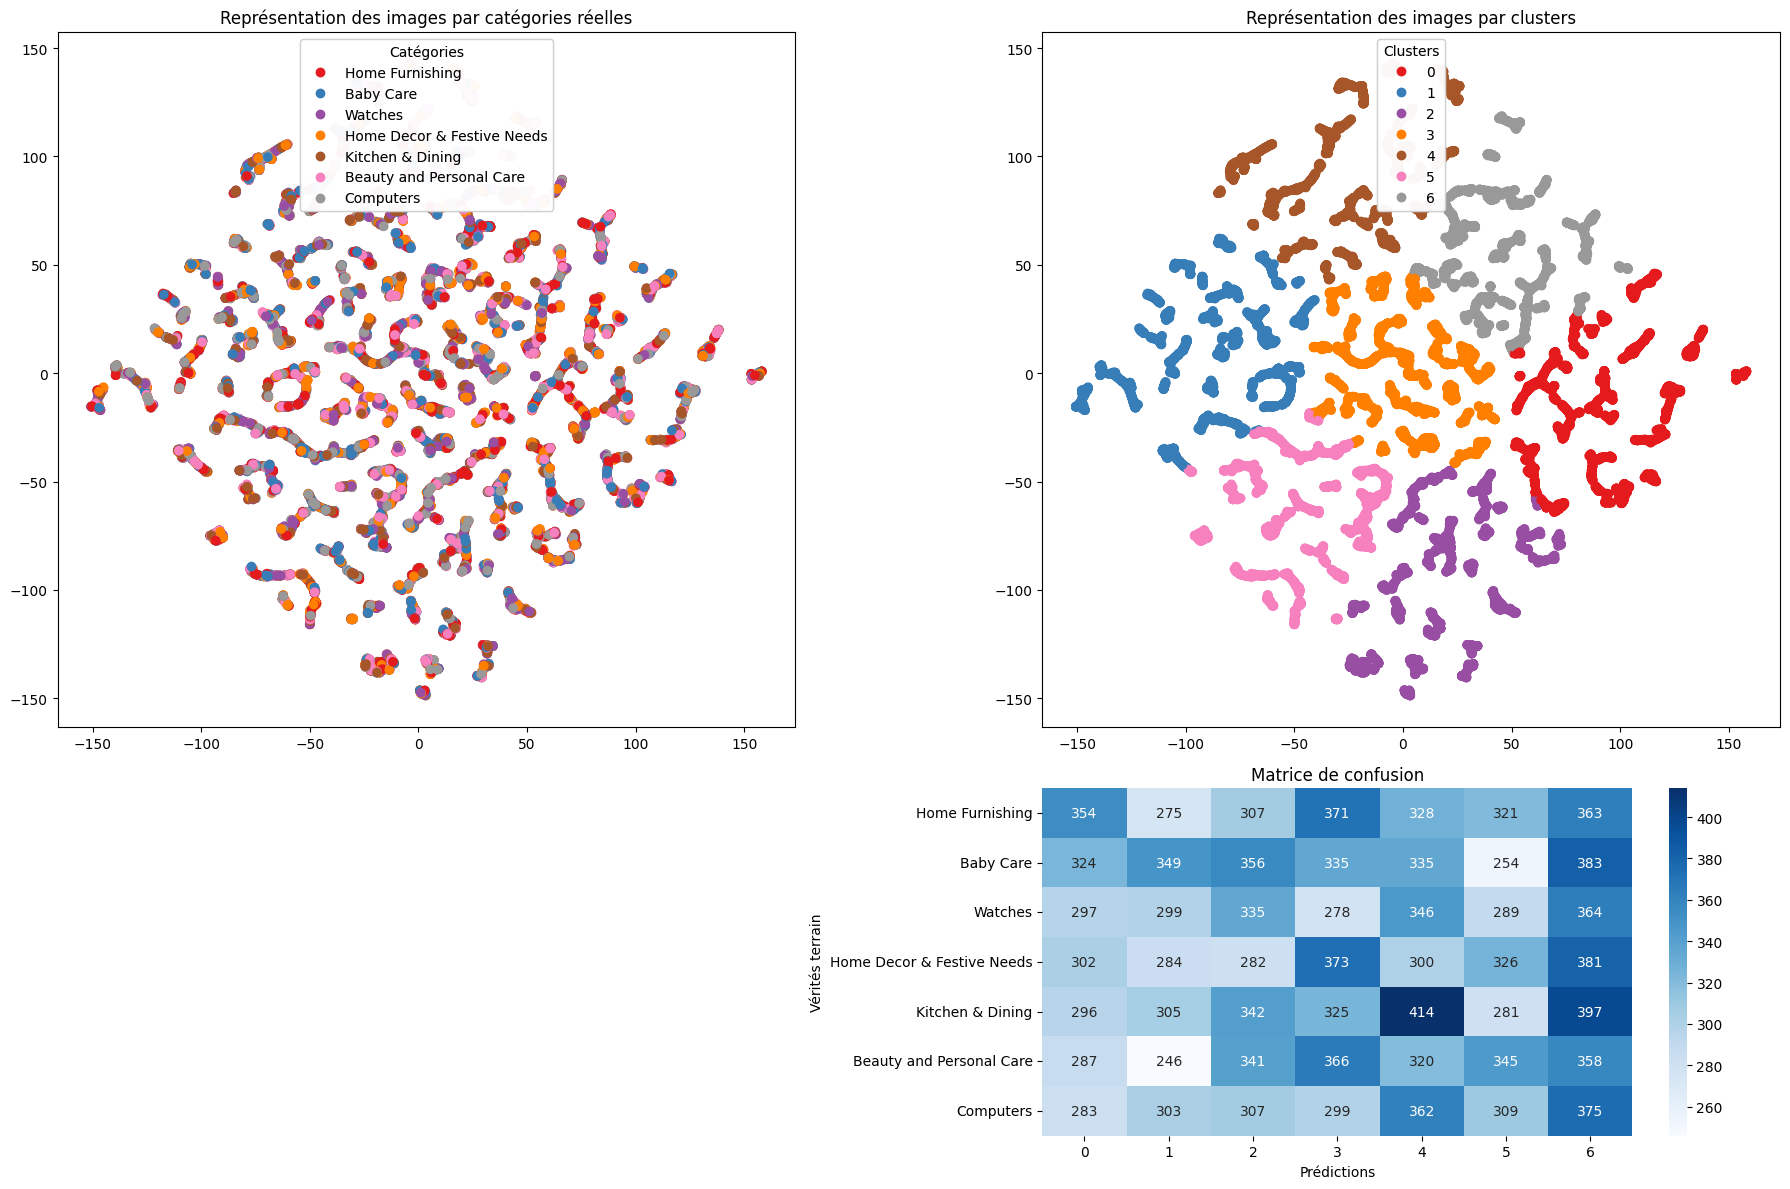

In [32]:
TSNE_visu_fct(X_tsne_train, y_train, labels_train, ARI_train, l_cat)

ARI :  0.0023 time :  16.0
Matrice de confusion originale:
 [[ 54 103 101  58  71  83  96]
 [ 53 136  75  94  57 104  85]
 [ 47 129  70  73  71 100 102]
 [ 62  89  78  72  74  98  79]
 [ 43 140  62  69  78  84  84]
 [ 69  78  76  54  89  97  94]
 [ 51 130  62  55  69  98  97]]
Matrice de confusion transformée:
 [[101  58  96  54 103  71  83]
 [ 75  94  85  53 136  57 104]
 [ 70  73 102  47 129  71 100]
 [ 78  72  79  62  89  74  98]
 [ 62  69  84  43 140  78  84]
 [ 76  54  94  69  78  89  97]
 [ 62  55  97  51 130  69  98]]


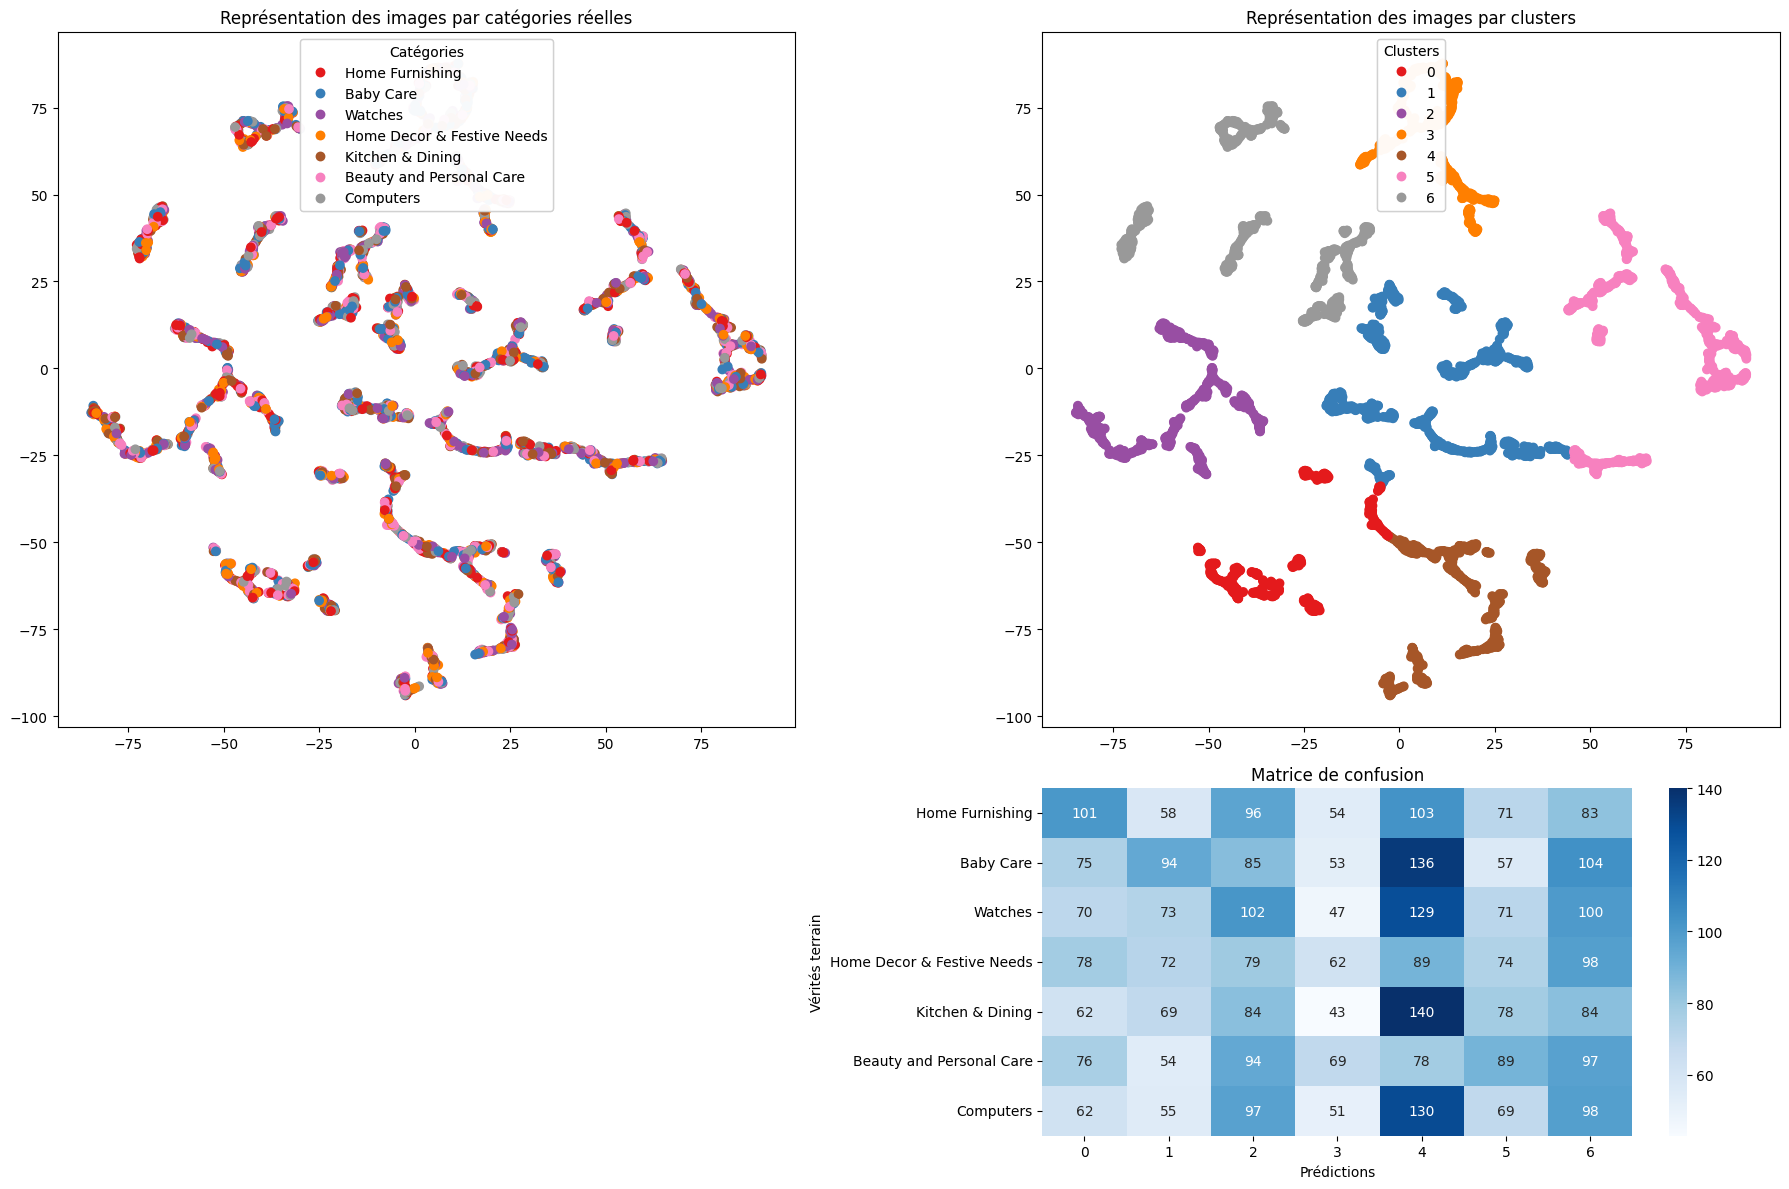

In [33]:
# Appliquer PCA et t-SNE sur les descripteurs de test
descriptors_tsne_test = apply_pca_tsne(descriptors_test)

# Effectuer le clustering sur les données de test transformées
cluster_labels_test = kmeans.predict(descriptors_tsne_test)

# Calculer ARI et visualiser les résultats pour les données de test
ARI_test, X_tsne_test, labels_test = ARI_fct(descriptors_tsne_test, l_cat, y_test)
TSNE_visu_fct(X_tsne_test, y_test, labels_test, ARI_test, l_cat)

### Conclusion

ORB donne de très mauvais résultat. On ne conservera pas ce choix.

## CNN

ORB donnant de très mauvais résultats nous avons choisis de nous orienter vers les réseaux de neuronnes convolutifs qui sont pertinents dans la classification d'image. 

Nous allons tester 2 modèles :
- VGG19
- MobileNet

### Préparation des données

In [34]:
# Définir image paths et categories
image_folder = './Flipkart/images'
image_paths = [os.path.join(image_folder, img) for img in data['image']]
categories = data['cat_product_1'].values

# Encoder les catégories
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(categories)

# Create a DataFrame with image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': categories})  # Garder les étiquettes comme des chaînes

# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [35]:
# Data Generators for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 735 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


In [36]:
# Pour les metriques
# Obtention des catégories uniques et des labels numériques
categories = data['cat_product_1']
l_cat = list(categories.unique())
y_cat_num = categories.apply(lambda x: l_cat.index(x))

### VGG19

In [37]:
# Charger le modèle VGG19 pré-entraîné sans les couches fully-connected
#base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajouter des nouvelles couches adaptées à votre tâche
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(512, activation='relu')(x)
#x = Dropout(0.5)(x)
#x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
#predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Nombre de classes dans la sortie

# Créer le modèle final
#model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle VGG19 pré-entraîné
#for layer in base_model.layers:
#    layer.trainable = False

# Compiler le modèle
#model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Determiner steps_per_epoch et validation_steps
#steps_per_epoch_vgg = train_generator.samples // train_generator.batch_size
#validation_steps_vgg = test_generator.samples // test_generator.batch_size

# Entraîner le modèle avec les nouvelles couches
#model.fit(
#    train_generator,
#    steps_per_epoch=steps_per_epoch_vgg,
#    epochs=10,
#    validation_data=test_generator,
#    validation_steps=validation_steps_vgg,
#    verbose=1
#)

# Dégeler quelques couches supérieures du modèle VGG19 et continuer l'entraînement
#for layer in base_model.layers[-4:]:  # Dégeler les 4 dernières couches
#    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage plus faible
#model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continuer l'entraînement avec les couches dégelées
#model.fit(
#    train_generator,
#    steps_per_epoch=steps_per_epoch_vgg,
#    epochs=10,
#    validation_data=test_generator,
#    validation_steps=validation_steps_vgg,
#    verbose=1
#)

#### Sauvegarde du modèle

In [38]:
# Sauvegarde du modèle
#model.save('VGG19_projet_6.keras')

In [39]:
# Charger le modèle
model_vgg19 = load_model('VGG19_projet_6.keras')

#### Evaluation

In [40]:
# Evaluation du modèle sur les données de test
loss, accuracy = model_vgg19.evaluate(test_generator)

# Affichage des résultats
print(f'Loss sur les données de test : {loss}')
print(f'Accuracy sur les données de test : {accuracy}')

/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.6821 - loss: 0.8605
Loss sur les données de test : 0.823518693447113
Accuracy sur les données de test : 0.723809540271759


#### Prédiction

In [41]:
# Faire des prédictions sur les données de test
predictions = model_vgg19.predict(test_generator)

# Afficher les premières prédictions
print(predictions[:5])

10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step
[[7.69622400e-02 5.02975658e-02 5.47780097e-01 2.46046986e-02
  2.68374234e-02 2.19057828e-01 5.44602126e-02]
 [4.83290441e-02 4.79221754e-02 1.13881789e-01 1.64623056e-02
  1.07448502e-02 3.52418900e-01 4.10240829e-01]
 [1.19649403e-01 1.25497028e-01 5.80843985e-01 2.69402731e-02
  1.18494034e-01 1.81122255e-02 1.04630515e-02]
 [1.39633092e-04 9.90230143e-01 4.70682106e-04 9.80843542e-05
  2.98473842e-05 8.91582482e-03 1.15839641e-04]
 [2.86418071e-05 1.92030675e-05 4.33742525e-06 7.43619385e-05
  8.03330204e-06 8.30949066e-05 9.99782264e-01]]


#### Metriques

In [42]:
# Utilisation de la fonction avec vos générateurs de données
train_features, train_labels = extract_features(train_generator, model_vgg19)
test_features, test_labels = extract_features(test_generator, model_vgg19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [43]:
# labels one-hot encoded, convertion en format d'indices de classe
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

In [44]:
# Calcul de l'ARI et visualisation avec TSNE
ARI, X_tsne, labels = ARI_fct(train_features, l_cat, train_labels)

ARI :  0.4672 time :  3.0


Matrice de confusion originale:
 [[ 8  0 10  1  8  2 76]
 [14  0  0 70 21  3  6]
 [80  0  1  3  8  5  1]
 [13  1  2  1  6 68 15]
 [ 2  0 65  0  2  0 29]
 [13  0  0  2 92  0  5]
 [15 84  0  0  2  1  0]]
Matrice de confusion transformée:
 [[76  1  8  2 10  8  0]
 [ 6 70 14  3  0 21  0]
 [ 1  3 80  5  1  8  0]
 [15  1 13 68  2  6  1]
 [29  0  2  0 65  2  0]
 [ 5  2 13  0  0 92  0]
 [ 0  0 15  1  0  2 84]]


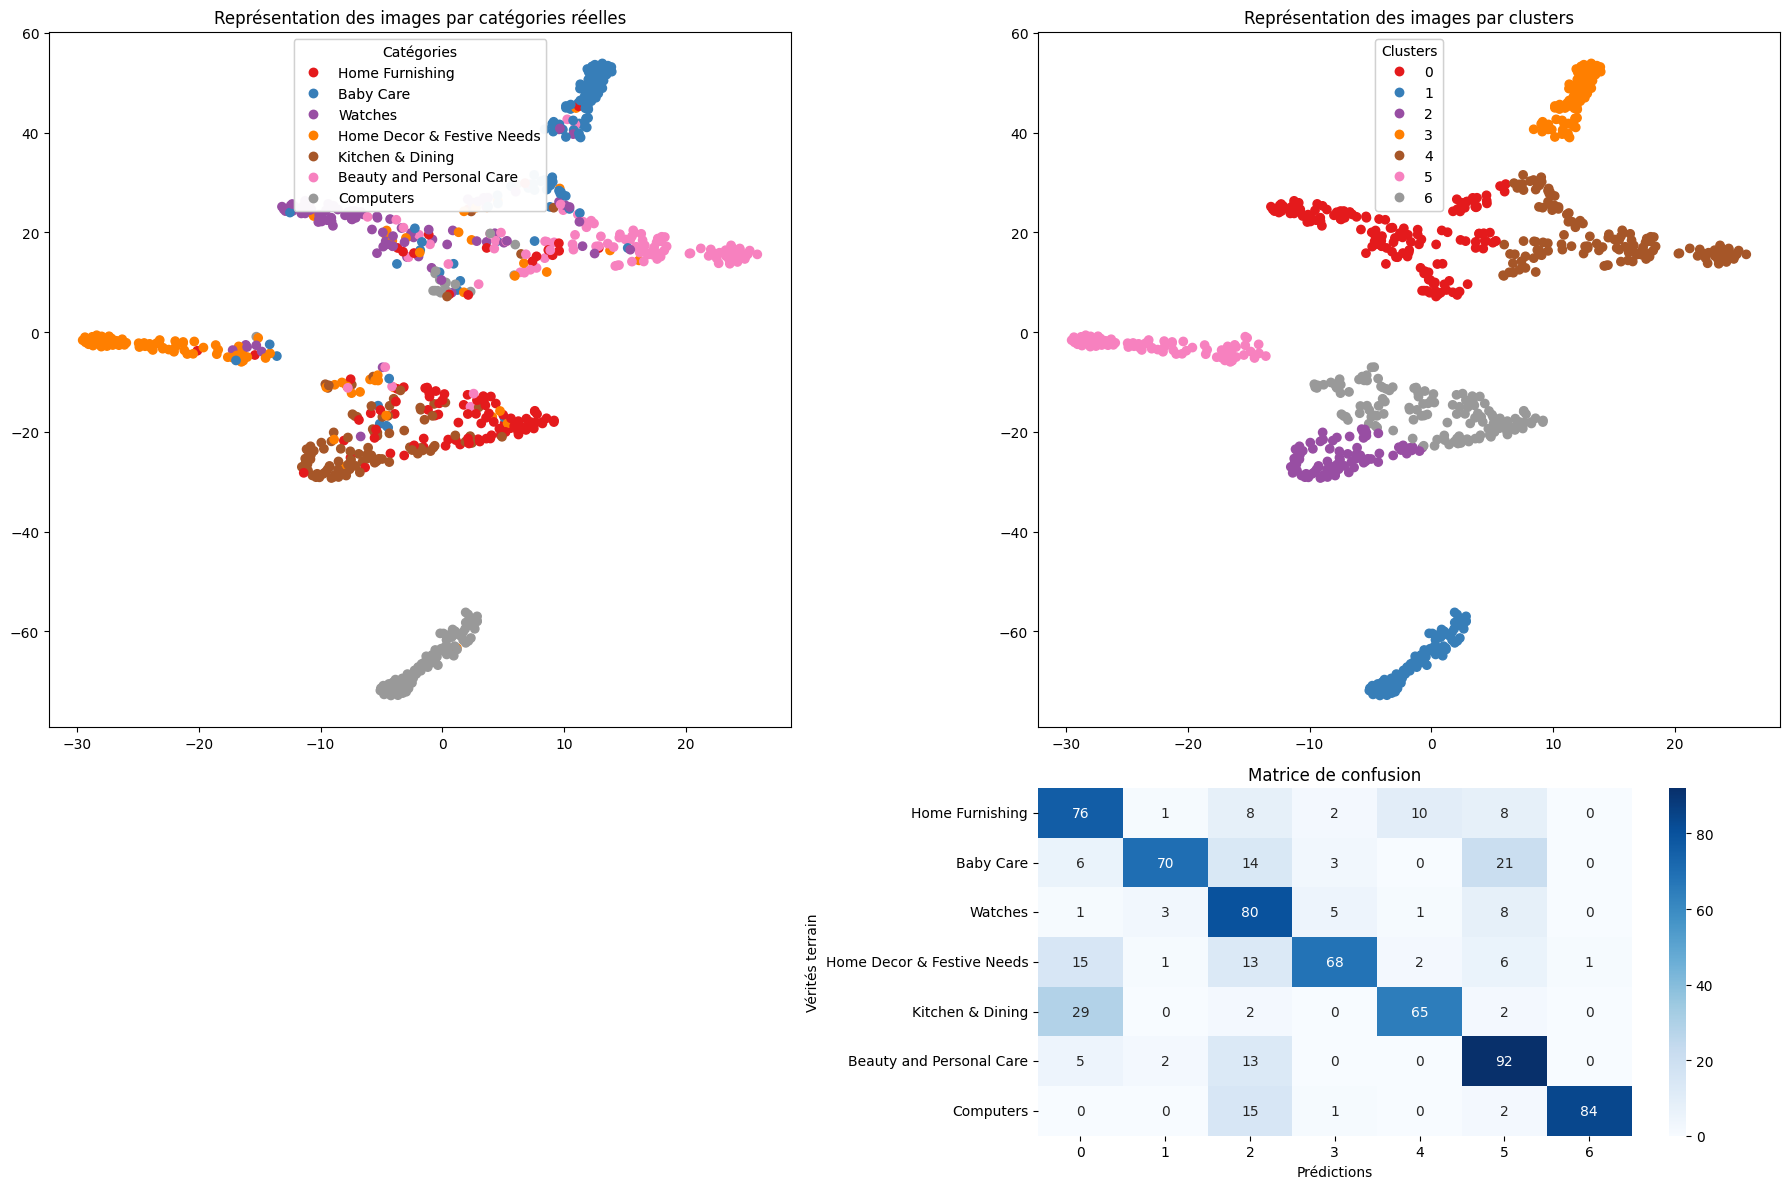

In [45]:
TSNE_visu_fct(X_tsne, train_labels, labels, ARI, l_cat)

## MobileNet

### Préparation des données

In [135]:
# Définir image paths et categories
image_folder = './Flipkart/images'
image_paths = [os.path.join(image_folder, img) for img in data['image']]
categories = data['cat_product_1'].values

# Encoder les catégories
label_encoder = LabelEncoder()
cat_encoder = label_encoder.fit_transform(categories)

# Create a DataFrame with image paths and labels
df_mobilenet = pd.DataFrame({'image_path': image_paths, 'label': categories})
display(df_mobilenet.head())

# Split the data into training and test sets
train_df_mobilenet, test_df_mobilenet = train_test_split(df_mobilenet, test_size=0.2, random_state=42)

image_path            label
0  ./Flipkart/images/55b85ea15a1536d46b7190ad6fff...  Home Furnishing
1  ./Flipkart/images/7b72c92c2f6c40268628ec5f14c6...        Baby Care
2  ./Flipkart/images/64d5d4a258243731dc7bbb1eef49...        Baby Care
3  ./Flipkart/images/d4684dcdc759dd9cdf41504698d7...  Home Furnishing
4  ./Flipkart/images/6325b6870c54cd47be6ebfbffa62...  Home Furnishing

In [136]:
batch_size = 32

# Data Generators for training and testing
train_datagen_mobilenet = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalisation des pixels
test_datagen_mobilenet = ImageDataGenerator(rescale=1./255)

train_generator_mobilenet = train_datagen_mobilenet.flow_from_dataframe(
    train_df_mobilenet,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator_mobilenet = test_datagen_mobilenet.flow_from_dataframe(
    test_df_mobilenet,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [137]:
# Pour les metriques
# Obtention des catégories uniques et des labels numériques
categories = data['cat_product_1']
l_cat = list(categories.unique())
y_cat_num = categories.apply(lambda x: l_cat.index(x))

In [138]:
class PyDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [139]:
num_classes = 7

# Charger MobileNet avec les paramètres par défaut et sans les poids ImageNet
base_model_mobile = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Ajouter les couches fully-connected au-dessus de MobileNet
x = base_model_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model_mobile = Model(inputs=base_model_mobile.input, outputs=predictions)

# Compiler le modèle
model_mobile.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Determiner steps_per_epoch et validation_steps
steps_per_epoch = len(train_df_mobilenet) // batch_size
validation_steps = len(test_df_mobilenet) // batch_size

print(steps_per_epoch,validation_steps )

26 6


In [140]:
# Afficher le résumé du modèle
model_mobile.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 3,542,791 (13.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [141]:
model_mobile.fit(
    train_generator_mobilenet,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_generator_mobilenet,
    validation_steps=validation_steps,
)

Epoch 1/10


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.3981 - loss: 1.6492 - val_accuracy: 0.7344 - val_loss: 0.8783
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6875 - loss: 0.9278 - val_accuracy: 0.7778 - val_loss: 0.6011
Epoch 3/10


2024-08-01 11:02:11.035180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/laurachatard/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-08-01 11:02:11.178225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


26/26 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7948 - loss: 0.6523 - val_accuracy: 0.7812 - val_loss: 0.6839
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8438 - loss: 0.5215 - val_accuracy: 0.8889 - val_loss: 0.4212
Epoch 5/10


2024-08-01 11:02:59.581289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-01 11:02:59.716106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


26/26 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8682 - loss: 0.4021 - val_accuracy: 0.7969 - val_loss: 0.6164
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8750 - loss: 0.3631 - val_accuracy: 0.8889 - val_loss: 0.3432
Epoch 7/10


2024-08-01 11:03:45.927647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-01 11:03:46.061659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9305 - loss: 0.2616 - val_accuracy: 0.7240 - val_loss: 0.7505
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9375 - loss: 0.2893 - val_accuracy: 0.8889 - val_loss: 0.3092
Epoch 9/10


2024-08-01 11:04:33.427677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-01 11:04:33.562517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


26/26 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9493 - loss: 0.1638 - val_accuracy: 0.7812 - val_loss: 0.6274
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9062 - loss: 0.2271 - val_accuracy: 0.8889 - val_loss: 0.2543


2024-08-01 11:05:20.750087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-01 11:05:20.893144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


### Sauvegarde

In [ ]:
# Sauvegarder le modèle
model_mobile.save('mobilenet_model.keras')

# Charger le modèle
model_mobile = load_model('mobilenet_model.keras')

### Metriques

In [142]:
# Utilisation de la fonction avec les générateurs de données
train_features, train_labels = extract_features(train_generator, model_mobile)
test_features, test_labels = extract_features(test_generator, model_mobile)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [143]:
print(train_labels.shape)
print(test_labels.shape)

(735, 7)
(315, 7)


In [144]:
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

ARI :  0.7387 time :  3.0
Matrice de confusion originale:
 [[  3   6   0   3  15   2  76]
 [ 96   2   0   8   4   3   1]
 [  0   2   0  94   2   0   0]
 [  1   0   0   1 102   1   1]
 [  1   0   0   8  11  77   1]
 [  2 102   0   3   5   0   0]
 [  0   0 100   2   0   0   0]]
Matrice de confusion transformée:
 [[ 76   3   3  15   2   6   0]
 [  1  96   8   4   3   2   0]
 [  0   0  94   2   0   2   0]
 [  1   1   1 102   1   0   0]
 [  1   1   8  11  77   0   0]
 [  0   2   3   5   0 102   0]
 [  0   0   2   0   0   0 100]]


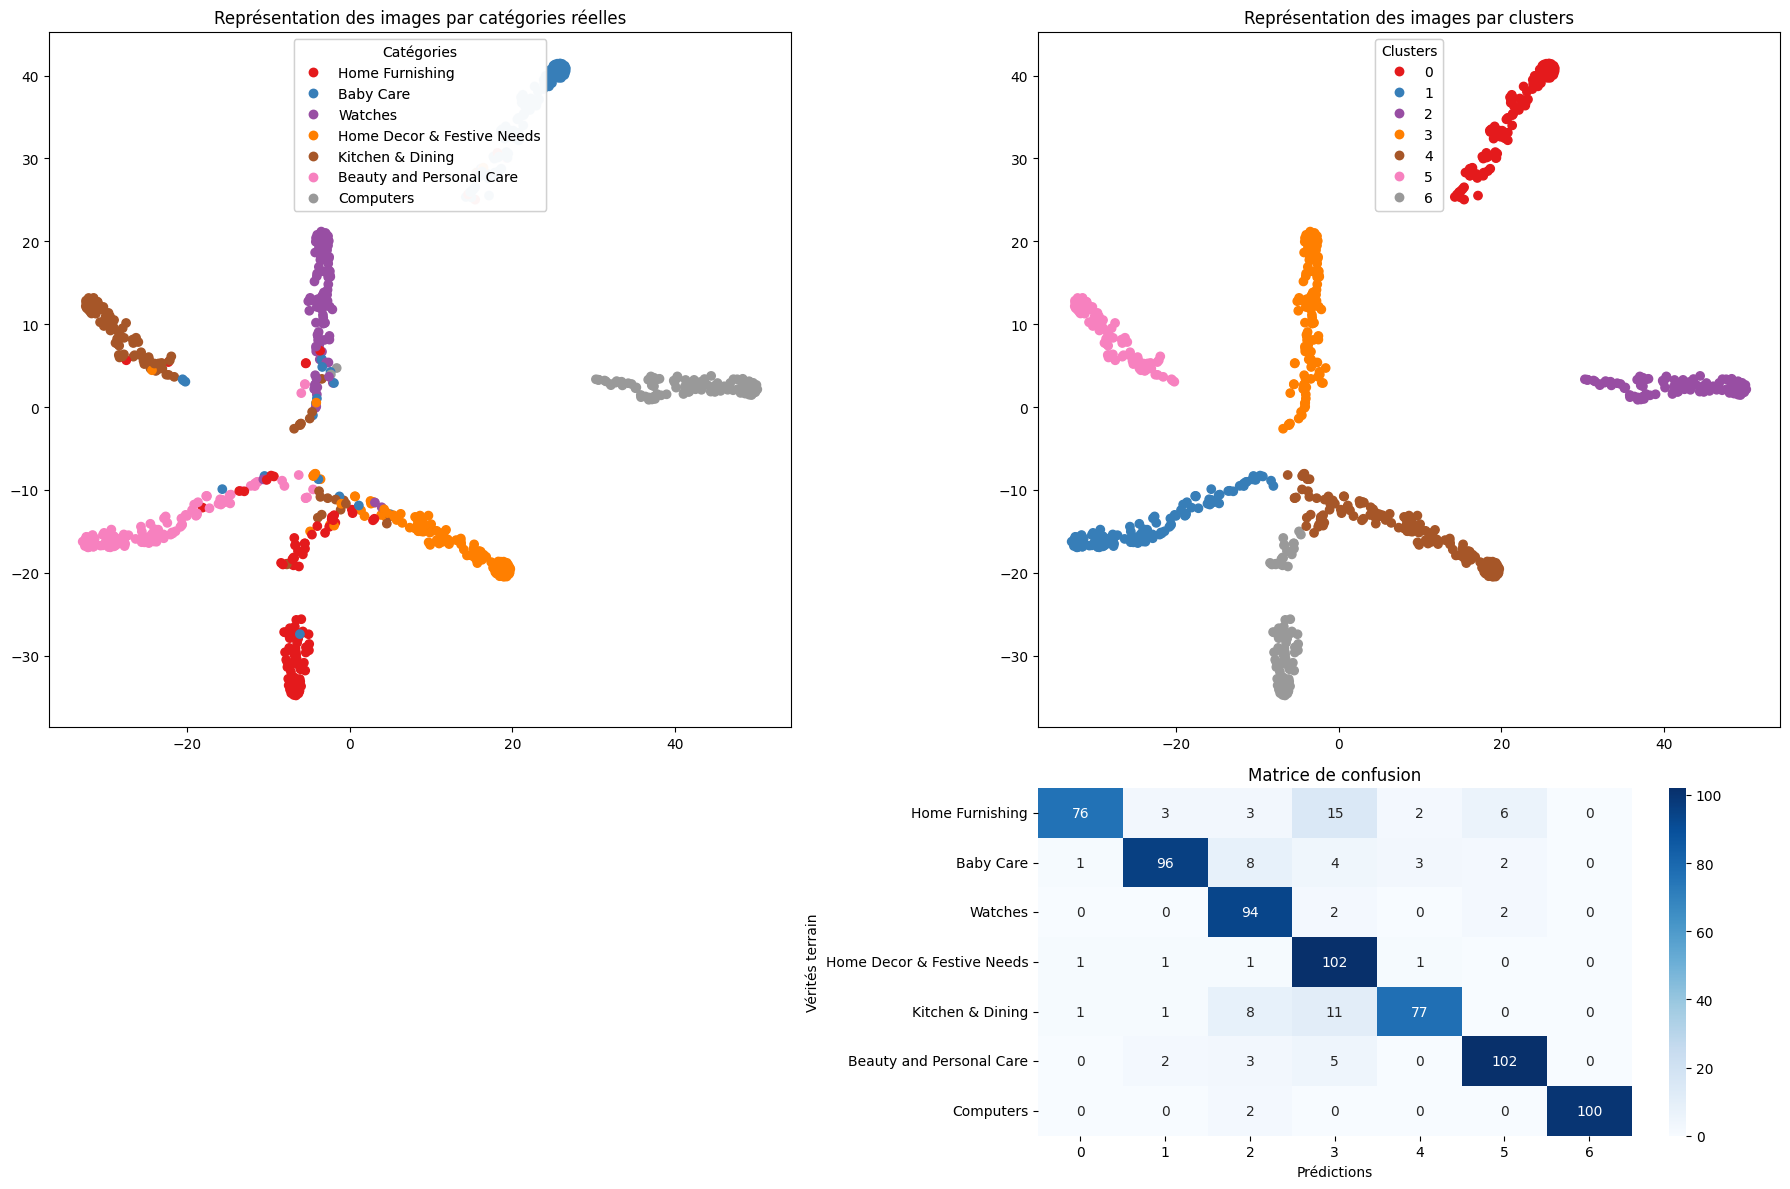

In [145]:
# Calcul de l'ARI et visualisation avec TSNE
ARI, X_tsne, labels = ARI_fct(train_features, l_cat, train_labels)
TSNE_visu_fct(X_tsne, train_labels, labels, ARI, l_cat)

ARI avec étiquettes permutées:
ARI :  0.0 time :  3.0
Matrice de confusion originale:
 [[11 20 16  9 19 16 14]
 [14 27 12 10 22 15 14]
 [17 19 17 12 13 13  7]
 [18 14 14 15 18 13 14]
 [10 18 10 11 14 18 17]
 [14 11 16 13 17 24 17]
 [19 17 15 14 11 19  7]]
Matrice de confusion transformée:
 [[19 20 16  9 14 16 11]
 [22 27 12 10 14 15 14]
 [13 19 17 12  7 13 17]
 [18 14 14 15 14 13 18]
 [14 18 10 11 17 18 10]
 [17 11 16 13 17 24 14]
 [11 17 15 14  7 19 19]]


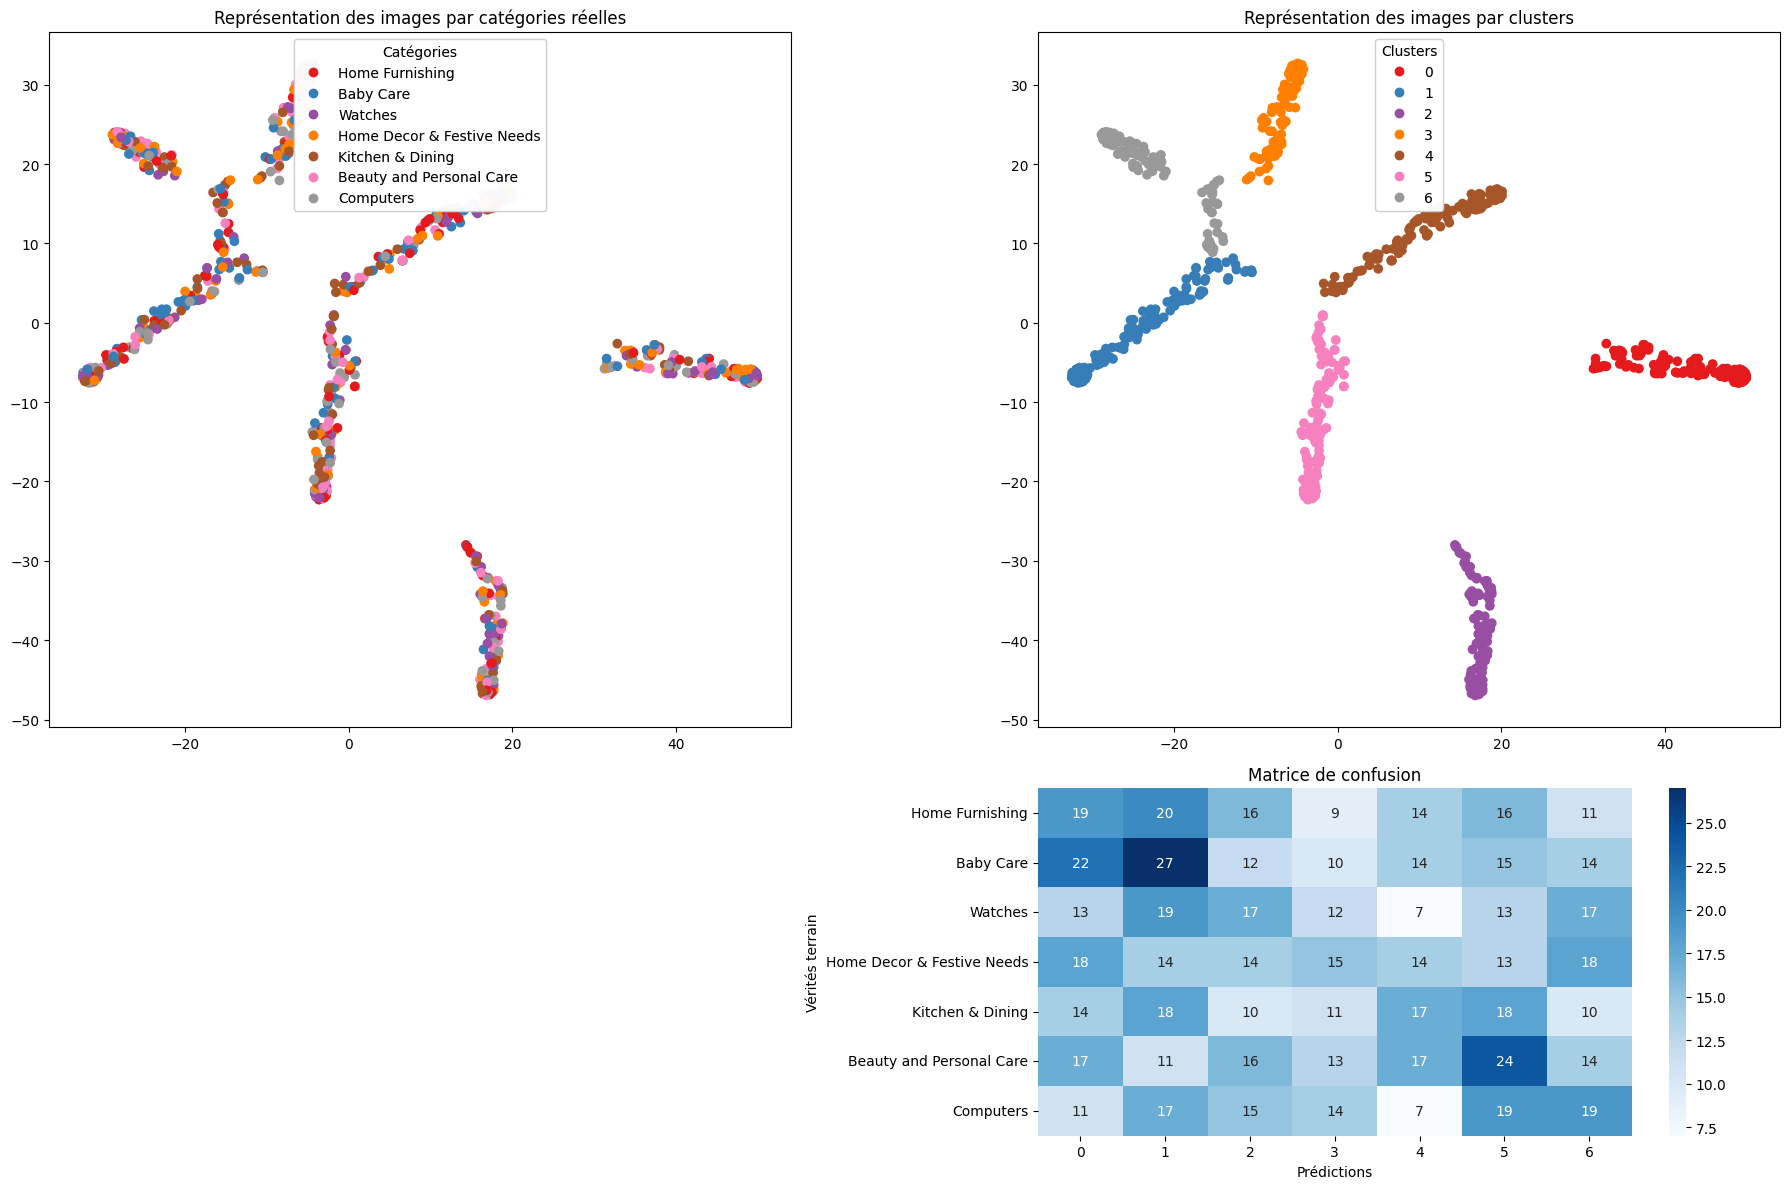

In [146]:
# Test robustesse ARI

# Permuter les étiquettes
np.random.shuffle(train_features)

# Calculer l'ARI avec des étiquettes permutées
print(f"ARI avec étiquettes permutées:")

ARI, X_tsne, labels = ARI_fct(train_features, l_cat, train_labels)
TSNE_visu_fct(X_tsne, train_labels, labels, ARI, l_cat)

# Conclusion

Le CNN MobileNet donne des résultat très satisfaisant dans la classification des images. Résultat confirmé par le test de robustesse. 